In [89]:
import smash
from smash.solver._mwd_cost import nse
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from preprocessing import load_data

In [90]:
smash.__version__

'0.4.2+3.gf3c9235'

## 1. Calibration Period

In [91]:
def df_cost(area):
    
    modelddt_unif = smash.read_model_ddt(f"models/{area}/uniform.hdf5")
    modelddt_ln = smash.read_model_ddt(f"models/{area}/hyper-linear.hdf5")
    modelddt_pl = smash.read_model_ddt(f"models/{area}/hyper-polynomial.hdf5")
    modelddt_ann = smash.read_model_ddt(f"models/{area}/ann.hdf5")

    gau = pd.read_csv(f"data/{area}/cal_code.csv")["cal"].to_list()
    ung = pd.read_csv(f"data/{area}/val_code.csv")["val"].to_list()

    code = []
    obs = []
    method = []
    cost = []

    for i, co in enumerate(modelddt_unif["code"]):

        if co in gau+ung:

            code += [co] * 6
            if co in gau:
                obs += [f"{area} Gauged ({len(gau)})"] * 6
            else:
                obs += [f"{area} Ungauged ({len(ung)})"] * 6
            
            # local unif
            method.append("Uniform (local)")
            cost.append(1 - smash.read_model_ddt(f"models/{area}/local-uniform/{co}.hdf5")["cal_cost"])

            # local distributed
            method.append("Distributed (local)")
            cost.append(1 - smash.read_model_ddt(f"models/{area}/local-distributed/{co}.hdf5")["cal_cost"])

            # global unif
            method.append("Uniform (regionalization)")
            cost.append(1 - nse(modelddt_unif["qobs"][i], modelddt_unif["qsim"][i]))

            # linear regio
            method.append("Multi-linear (regionalization)")
            cost.append(1 - nse(modelddt_ln["qobs"][i], modelddt_ln["qsim"][i]))

            # poly regio
            method.append("Multi-polynomial (regionalization)")
            cost.append(1 - nse(modelddt_pl["qobs"][i], modelddt_pl["qsim"][i]))

            # ann regio
            method.append("ANN (regionalization)")
            cost.append(1 - nse(modelddt_ann["qobs"][i], modelddt_ann["qsim"][i]))

    return pd.DataFrame({"code": code, "obs": obs, "method": method, "NSE": cost})

In [92]:
df1 = df_cost("MedEst")
df2 = df_cost("Ardeche")

df = pd.concat([df1, df2], ignore_index=True)

# df.to_csv("cost_cal_period.csv", index=False)
# df = pd.read_csv("cost_cal_period.csv")

In [93]:
df.head()

,code,obs,method,NSE
0,Y4624010,MedEst Gauged (9),Uniform (local),0.519397
1,Y4624010,MedEst Gauged (9),Distributed (local),0.773740
2,Y4624010,MedEst Gauged (9),Uniform (regionalization),0.359392
3,Y4624010,MedEst Gauged (9),Multi-linear (regionalization),0.694059
4,Y4624010,MedEst Gauged (9),Multi-polynomial (regionalization),0.715963


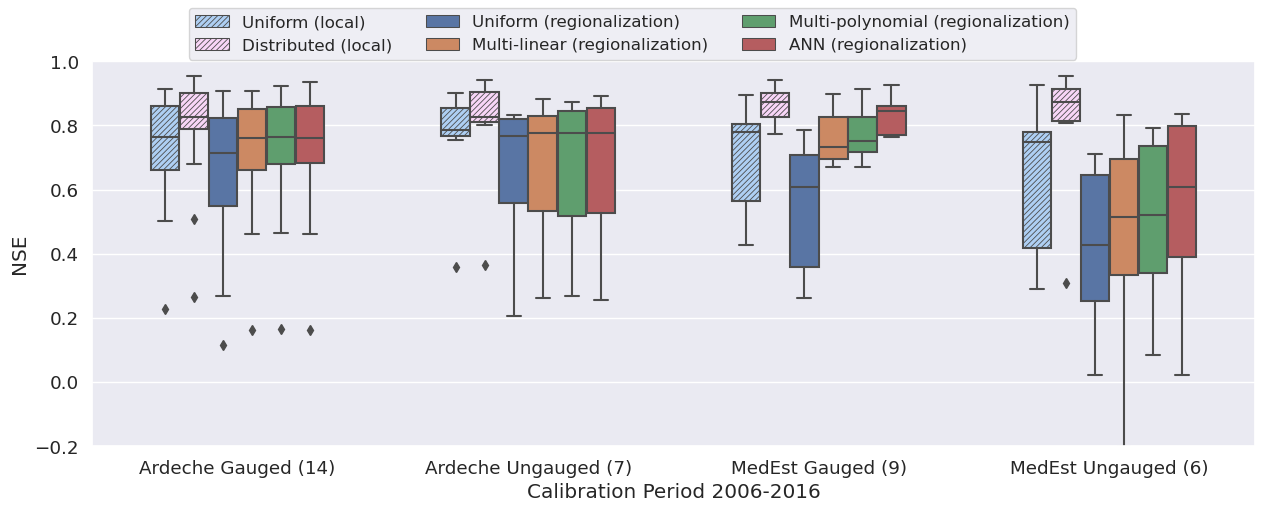

In [94]:
ord = df.obs.unique()
ord.sort()

colors = [
        "#a2cffe",
        "#fed0fc",
        "#4c72b0",
        "#dd8452",
        "#55a868",
        "#c44e52",
    ]

sns.set(font_scale=1.2)

fig, ax = plt.subplots(figsize=(15,5))

bplt = sns.boxplot(
        data=df,
        x="obs",
        y="NSE",
        hue="method",
        width=0.6,
        palette=colors,
        order=ord,
        showfliers=True,
    )

# Set hatch pattern
hatch = "//////"
mpl.rcParams['hatch.linewidth'] = 0.6
for i in range(4):
    bplt.patches[i].set_hatch(hatch)
for i in range(2, 5):
    bplt.patches[i*len(colors)].set_hatch(hatch) 
    bplt.patches[i*len(colors)+1].set_hatch(hatch) 

# Set title and axis labels
ax.set(title=None, xlabel="Calibration Period 2006-2016")

ax.set_ylim([-0.2, 1])

handles, labels = ax.get_legend_handles_labels()  # get labels then remove
ax.legend([], [], frameon=False)

# Add legend
fig.legend(
    handles,
    labels,
    title=None,
    loc="upper center",
    ncol=3,
    fontsize=12,
)

## 2. Validation Period

In [95]:
def df_cost_val(area, start_time="2016-08-01 00:00", end_time="2018-08-01 00:00"):
    
    modelddt_unif = smash.read_model_ddt(f"models/{area}/uniform.hdf5")
    modelddt_ln = smash.read_model_ddt(f"models/{area}/hyper-linear.hdf5")
    modelddt_pl = smash.read_model_ddt(f"models/{area}/hyper-polynomial.hdf5")
    modelddt_ann = smash.read_model_ddt(f"models/{area}/ann.hdf5")

    model = smash.Model(
        *load_data(
            f"data/{area}/info_bv.csv",
            start_time=start_time,
            end_time=end_time,
            desc_dir="...",
        )
    )
    
    params = model.get_bound_constraints(states=False)["names"]
    
    for par in params:
        setattr(model.parameters, par, modelddt_unif[par])
    model_unif = model.run()

    for par in params:
        setattr(model.parameters, par, modelddt_ln[par])
    model_ln = model.run()

    for par in params:
        setattr(model.parameters, par, modelddt_pl[par])
    model_pl = model.run()

    for par in params:
        setattr(model.parameters, par, modelddt_ann[par])
    model_ann = model.run()

    gau = pd.read_csv(f"data/{area}/cal_code.csv")["cal"].to_list()
    ung = pd.read_csv(f"data/{area}/val_code.csv")["val"].to_list()

    code = []
    obs = []
    method = []
    cost = []

    for i, co in enumerate(modelddt_unif["code"]):

        if co in gau+ung:

            code += [co] * 6
            if co in gau:
                obs += [f"{area} Gauged ({len(gau)})"] * 6
            else:
                obs += [f"{area} Ungauged ({len(ung)})"] * 6
            
            # local unif
            method.append("Uniform (local)")
            modelddt_localunif = smash.read_model_ddt(f"models/{area}/local-uniform/{co}.hdf5")
            info_catch = pd.read_csv(f"data/{area}/info_bv.csv")
            model_localunif = smash.Model(
                                *load_data(
                                    info_catch[info_catch.Code_BV==co],
                                    start_time=start_time,
                                    end_time=end_time,
                                    desc_dir="...",
                                )
                            )
            for par in params:
                setattr(model_localunif.parameters, par, modelddt_localunif[par])
            model_localunif.run(inplace=True)
            cost.append(1 - nse(model_localunif.input_data.qobs[0], model_localunif.output.qsim[0]))

            # local distributed
            method.append("Distributed (local)")
            modelddt_localdist = smash.read_model_ddt(f"models/{area}/local-distributed/{co}.hdf5")
            info_catch = pd.read_csv(f"data/{area}/info_bv.csv")
            model_localdist = smash.Model(
                                *load_data(
                                    info_catch[info_catch.Code_BV==co],
                                    start_time=start_time,
                                    end_time=end_time,
                                    desc_dir="...",
                                )
                            )
            for par in params:
                setattr(model_localdist.parameters, par, modelddt_localdist[par])
            model_localdist.run(inplace=True)
            cost.append(1 - nse(model_localdist.input_data.qobs[0], model_localdist.output.qsim[0]))
    
            # global unif
            method.append("Uniform (regionalization)")
            cost.append(1 - nse(model_unif.input_data.qobs[i], model_unif.output.qsim[i]))

            # linear regio
            method.append("Multi-linear (regionalization)")
            cost.append(1 - nse(model_ln.input_data.qobs[i], model_ln.output.qsim[i]))

            # poly regio
            method.append("Multi-polynomial (regionalization)")
            cost.append(1 - nse(model_pl.input_data.qobs[i], model_pl.output.qsim[i]))

            # ann regio
            method.append("ANN (regionalization)")
            cost.append(1 - nse(model_ann.input_data.qobs[i], model_ann.output.qsim[i]))

    return pd.DataFrame({"code": code, "obs": obs, "method": method, "NSE": cost})

In [9]:
df1val = df_cost_val("MedEst")
df2val = df_cost_val("Ardeche")

dfval = pd.concat([df1val, df2val], ignore_index=True)

# dfval.to_csv("cost_val_period.csv", index=False)
# dfval = pd.read_csv("cost_val_period.csv")

In [88]:
dfval.head()

,code,obs,method,NSE
0,Y4624010,MedEst Gauged (9),Uniform (local),0.195964
1,Y4624010,MedEst Gauged (9),Distributed (local),0.325710
2,Y4624010,MedEst Gauged (9),Uniform (regionalization),0.250365
3,Y4624010,MedEst Gauged (9),Multi-linear (regionalization),0.760497
4,Y4624010,MedEst Gauged (9),Multi-polynomial (regionalization),0.796493


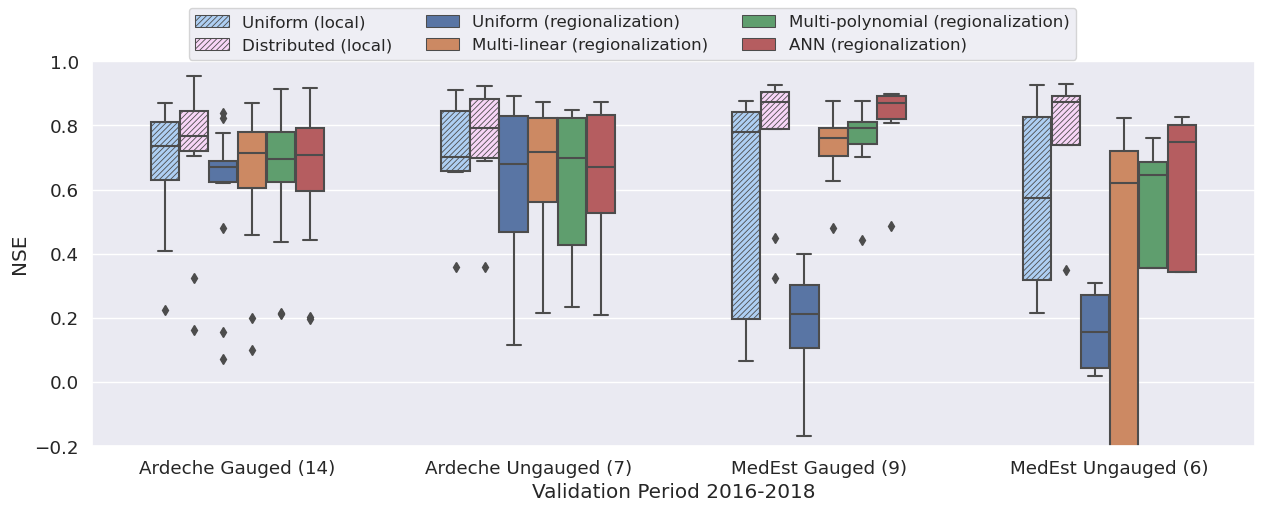

In [97]:
fig, ax = plt.subplots(figsize=(15,5))

bplt = sns.boxplot(
        data=dfval,
        x="obs",
        y="NSE",
        hue="method",
        width=0.6,
        palette=colors,
        order=ord,
        showfliers=True,
    )

# Set hatch pattern
hatch = "//////"
mpl.rcParams['hatch.linewidth'] = 0.6
for i in range(4):
    bplt.patches[i].set_hatch(hatch)
for i in range(2, 5):
    bplt.patches[i*len(colors)].set_hatch(hatch) 
    bplt.patches[i*len(colors)+1].set_hatch(hatch) 

# Set title and axis labels
ax.set(title=None, xlabel="Validation Period 2016-2018")

ax.set_ylim([-0.2, 1])

handles, labels = ax.get_legend_handles_labels()  # get labels then remove
ax.legend([], [], frameon=False)

# Add legend
fig.legend(
    handles,
    labels,
    title=None,
    loc="upper center",
    ncol=3,
    fontsize=12,
)